<a href="https://colab.research.google.com/github/Dinillll/DL-Lab-08/blob/main/LunarLander_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Lab7part2.zip -d data

Archive:  /content/drive/MyDrive/Lab7part2.zip
   creating: data/Lab7(part2)/
   creating: data/Lab7(part2)/IT22298126/
  inflating: data/Lab7(part2)/IT22298126/DQN_Gridworld.ipynb  
  inflating: data/Lab7(part2)/IT22298126/LunarLander_DQN.ipynb  


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Q-network definition
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)


In [3]:
# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )
    def __len__(self):
        return len(self.buffer)


In [4]:
# DQN agent with ε-greedy policy, experience replay and target network
class DQNAgent:
    def __init__(self,
                 state_dim,
                 action_dim,
                 gamma=0.99,
                 lr=1e-3,
                 buffer_size=50000,
                 batch_size=64,
                 target_update_freq=1000,
                 epsilon_start=1.0,
                 epsilon_end=0.01,
                 epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Epsilon parameters
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Networks
        self.policy_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # target network not trained directly

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayBuffer(buffer_size)
        self.steps_done = 0

    def select_action(self, state):
        # ε-greedy action selection
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                return int(q_values.argmax())

    def optimize(self):
        # Skip if replay buffer isn't populated enough
        if len(self.memory) < self.batch_size:
            return None
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Current Q-values: Q(s,a)
        q_values = self.policy_net(states).gather(1, actions.view(-1, 1)).squeeze()

        # Target Q-values using target network
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = nn.functional.mse_loss(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [5]:
# Training function
def train_lunarlander(episodes=500):
    env = gym.make('LunarLander-v3')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)
    rewards_history = []
    epsilon_history = []
    losses = []

    for ep in range(episodes):
        # For Gymnasium, env.reset() returns (observation, info)
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            # For Gymnasium, env.step() returns (obs, reward, terminated, truncated, info)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.memory.push(state, action, reward, next_state, float(done))
            loss = agent.optimize()
            if loss is not None:
                losses.append(loss)
            state = next_state
            total_reward += reward

            # Periodically update target network
            if agent.steps_done % agent.target_update_freq == 0:
                agent.update_target_network()
            agent.steps_done += 1

        agent.decay_epsilon()
        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)

        if (ep + 1) % 20 == 0:
            print(f'Episode {ep+1}/{episodes}: total reward = {total_reward:.1f}, epsilon = {agent.epsilon:.3f}')

    env.close()
    return rewards_history, epsilon_history, losses


In [6]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409500 sha256=9851709a2cc076481c7f272ec726ce8fbbfcd50b4e5d5aaffc45a1bb12387526
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


/tmp/ipython-input-3569045532.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  torch.tensor(states, dtype=torch.float32),


Episode 20/300: total reward = -318.4, epsilon = 0.905
Episode 40/300: total reward = -116.5, epsilon = 0.818
Episode 60/300: total reward = -143.7, epsilon = 0.740
Episode 80/300: total reward = -82.8, epsilon = 0.670
Episode 100/300: total reward = -14.0, epsilon = 0.606
Episode 120/300: total reward = -68.1, epsilon = 0.548
Episode 140/300: total reward = -116.9, epsilon = 0.496
Episode 160/300: total reward = -461.0, epsilon = 0.448
Episode 180/300: total reward = -15.1, epsilon = 0.406
Episode 200/300: total reward = -61.1, epsilon = 0.367
Episode 220/300: total reward = -11.6, epsilon = 0.332
Episode 240/300: total reward = 156.8, epsilon = 0.300
Episode 260/300: total reward = -75.4, epsilon = 0.272
Episode 280/300: total reward = 73.6, epsilon = 0.246
Episode 300/300: total reward = 130.5, epsilon = 0.222


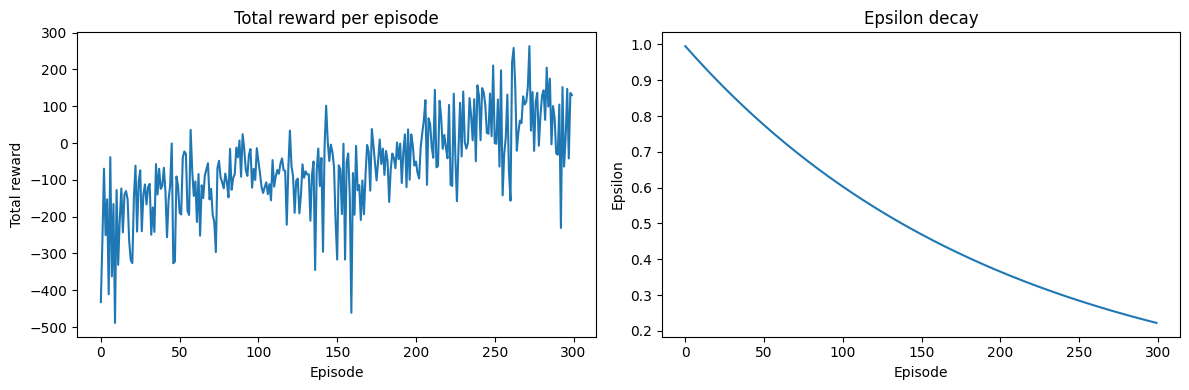

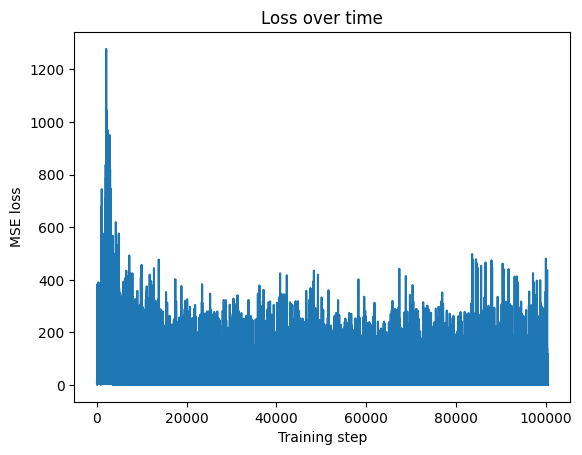

In [7]:
# Run training and plot results
rewards, epsilons, losses = train_lunarlander(episodes=300)

# Plot episode rewards and epsilon decay
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Total reward per episode')
plt.subplot(1,2,2)
plt.plot(epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon decay')
plt.tight_layout()
plt.show()

# plot loss history
plt.figure()
plt.plot(losses)
plt.xlabel('Training step')
plt.ylabel('MSE loss')
plt.title('Loss over time')
plt.show()